In [45]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.neighbors import KernelDensity
from sklearn.grid_search import GridSearchCV


In [51]:
df = pd.read_pickle('../data/robbery-street.p')
#df.head(3)

In [59]:
df['month'] = df.date.apply(lambda x: x.month)
df['year'] = df.date.apply(lambda x: x.year)
df.head(3)

,address,date,dayofweek,descript,time,x,y,nhood,tractce10,police_district,hist_police_district,month,year
0,400 Block of 6TH AV,2015-08-18,Tuesday,"ROBBERY ON THE STREET, STRONGARM",08:55:00,-122.464280,37.780033,Inner Richmond,045200,RICHMOND,RICHMOND,8,2015
1,19TH ST / CAPP ST,2015-08-20,Thursday,ROBBERY ON THE STREET WITH A DANGEROUS WEAPON,03:50:00,-122.418120,37.760301,Mission,020800,MISSION,MISSION,8,2015
2,COLUMBUS AV / NORTHPOINT ST,2015-11-05,Thursday,"ROBBERY ON THE STREET, STRONGARM",20:47:00,-122.418383,37.805978,North Beach,010100,CENTRAL,CENTRAL,11,2015


## Join weather and robberies

In [97]:
weather = pd.read_pickle(r"../data/noaa-weather-downtown-sf.p")
weather.head(3)

,DATE,PRCP,TMAX,TMIN
0,2003-01-01,0.0,15.0,7.8
1,2003-01-02,0.0,13.9,8.9
2,2003-01-03,0.0,17.2,8.3


In [102]:
print df.shape
df = df.merge(weather,how="inner",left_on="date",right_on="DATE")
print df.shape
df.head(3)


(25087, 13)
(25087, 17)


,address,date,dayofweek,descript,time,x,y,nhood,tractce10,police_district,hist_police_district,month,year,DATE,PRCP,TMAX,TMIN
0,400 Block of 6TH AV,2015-08-18,Tuesday,"ROBBERY ON THE STREET, STRONGARM",08:55:00,-122.464280,37.780033,Inner Richmond,045200,RICHMOND,RICHMOND,8,2015,2015-08-18,0.0,21.1,15.0
1,800 Block of 26TH AV,2015-08-18,Tuesday,ROBBERY ON THE STREET WITH A GUN,23:35:00,-122.485397,37.773433,Outer Richmond,047702,RICHMOND,RICHMOND,8,2015,2015-08-18,0.0,21.1,15.0
2,700 Block of MOSCOW ST,2015-08-18,Tuesday,ATTEMPTED ROBBERY ON THE STREET W/DEADLY WEAPON,21:30:00,-122.431690,37.715773,Excelsior,026302,INGLESIDE,INGLESIDE,8,2015,2015-08-18,0.0,21.1,15.0


## Aggregate by year, ignoring 2016

In [68]:
df.year.value_counts()

2006    2506
2008    2277
2007    2215
2012    2162
2005    1966
2013    1963
2009    1942
2011    1915
2010    1866
2004    1788
2003    1604
2014    1360
2015    1325
2016     198
Name: date, dtype: int64

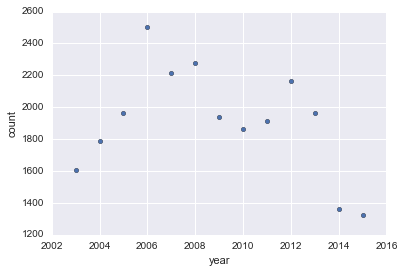

In [95]:
temp = df[df.year < 2016].year.value_counts().to_frame(name="count")
temp['year'] = temp.index
temp.plot(kind="scatter",x="year",y="count")

## Aggregate by month, ignoring 2016

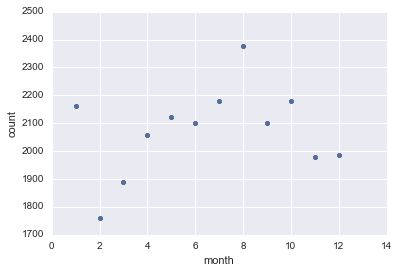

In [94]:
temp = df[df.year < 2016].month.value_counts().to_frame(name="count")
temp['month'] = temp.index
temp.plot(kind="scatter",x="month",y="count")

## Aggregate by time of date

In [60]:
def time2num(t):
    ts = t.hour * 60 + t.minute
    return ts

def num2time(ts):
    minute = ts % 60
    hour = (ts - minute) / 60
    return datetime.time(hour,minute)

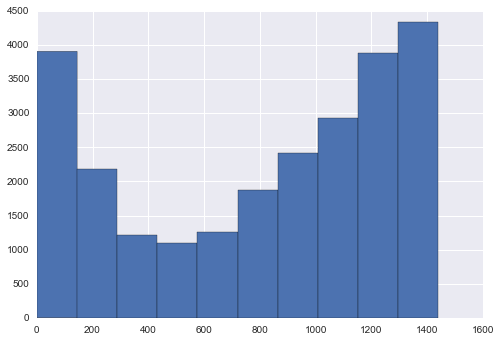

In [8]:
p = df.time.apply(time2num).hist()

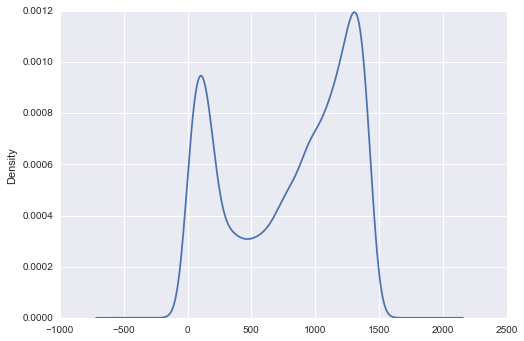

In [9]:
p = df.time.apply(time2num).plot.kde()


## Aggregate by day of week

Saturday     3792
Sunday       3745
Monday       3592
Friday       3516
Tuesday      3492
Wednesday    3491
Thursday     3459
Name: dayofweek, dtype: int64


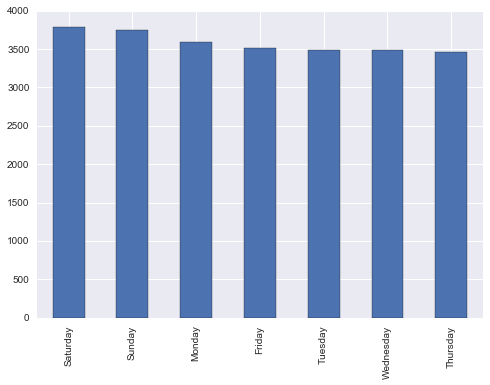

In [13]:
print df.dayofweek.value_counts()
p = df.dayofweek.value_counts().plot.bar()

## by TMAX

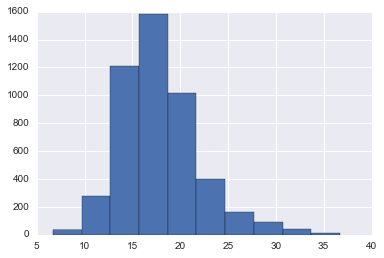

In [106]:
weather.TMAX.hist()

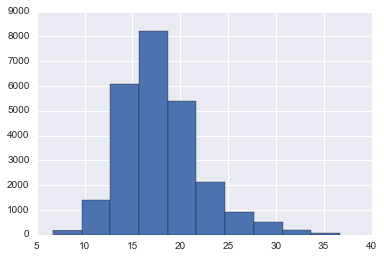

In [105]:
p = df.TMAX.hist()

In [118]:
kde = KernelDensity()
kde.fit(weather.TMAX.reshape(-1,1))
tgrid = np.linspace(weather.TMAX.min(),weather.TMAX.max()).reshape(-1,1)
kde.score_samples(tgrid)

array([-7.23781581, -6.59134835, -6.07827857, -5.64097187, -5.21135807,
       -4.76173505, -4.31942482, -3.91996506, -3.57489459, -3.27474523,
       -3.00878809, -2.78070089, -2.59908179, -2.45880028, -2.34471392,
       -2.2518081 , -2.18849799, -2.16213653, -2.17454057, -2.22902238,
       -2.32986705, -2.47287543, -2.64467985, -2.83718268, -3.05475013,
       -3.29670973, -3.53873046, -3.74610254, -3.91076872, -4.05471755,
       -4.19494835, -4.33231282, -4.47062033, -4.62233196, -4.79014965,
       -4.95351343, -5.08379239, -5.17433846, -5.24629431, -5.3373097 ,
       -5.48606954, -5.69989022, -5.9368091 , -6.14961156, -6.34951579,
       -6.57494944, -6.81542409, -7.03479175, -7.27765554, -7.65998629])

In [119]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.1, 1.0, 30)},
                    cv=5) # 20-fold cross-validation
grid.fit(weather.TMAX.as_matrix().reshape(-1,1))
print grid.best_params_
kde_TMAX = grid.best_estimator_

{'bandwidth': 0.10000000000000001}


In [120]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.1, 1.0, 30)},
                    cv=5) # 20-fold cross-validation
grid.fit(df.TMAX.as_matrix().reshape(-1,1))
print grid.best_params_
kde_robs = grid.best_estimator_

{'bandwidth': 0.10000000000000001}


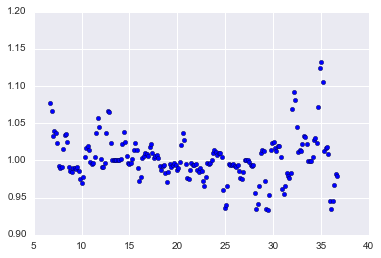

In [122]:
tgrid = np.linspace(weather.TMAX.min(),weather.TMAX.max(),num=200).reshape(-1,1)
cond = kde_robs.score_samples(tgrid)/kde_TMAX.score_samples(tgrid)

plt.scatter(tgrid, cond)

## By location

In [50]:
np.histogram2d(df.x,df.y)

(array([[  2.50850000e+04,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
      

In [46]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.1, 1.0, 30)},
                    cv=5) # 20-fold cross-validation
grid.fit(df[['x','y']])
print grid.best_params_
kde = grid.best_estimator_

{'bandwidth': 0.3172413793103448}


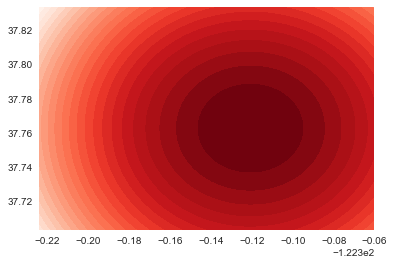

In [48]:
xmin = -122.5237517
xmax = -122.3602017
ymin = 37.7040012
ymax = 37.8341382

xv, yv = np.meshgrid(np.linspace(xmin,xmax,num=200),np.linspace(ymin,ymax,num=200))

X_grid = np.vstack([xv.ravel(), yv.ravel()]).transpose()



Z = kde.score_samples(X_grid)
Z = Z.reshape(xv.shape)

levels = np.linspace(Z.min(), Z.max(), 25)
plt.contourf(xv, yv, Z, levels=levels, cmap=plt.cm.Reds)